In [1]:
import matplotlib.pyplot as plt
import keras
import numpy as np
import PIL
from matplotlib import image
from os import listdir
import os

from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# loading all of the images, resizing them,
# and storing them in a dictionary according to
# their respective classifications

loaded_images = {}

trick_classes = [
    '50-50 Grinds',
    '5-0 Grinds',
    'Feeble Grinds',
    'Smith Grinds',
    'C-OC-N Grinds',
    'Lipslides and Boardslides',
    'Noseslides and Tailslides'
]

for trick in trick_classes:
    img_num = 1
    image_directory = 'Skate Images/{}'.format(trick)
    
    for filename in listdir(image_directory):
        if '.DS_Store' in filename:
            continue
        if trick not in loaded_images.keys():
            loaded_images[trick] = []
        else:
            img_loc = 'Skate Images/{}/{}'.format(trick, filename)
            img_resized_loc = '{}/original-resized-{}.jpg'.format(image_directory, img_num)
            
            img = PIL.Image.open(img_loc)
            img_resized = img.resize((227,227))
            
            img_resized.save(img_resized_loc)            

            img_resized_data = image.imread(img_resized_loc)

            if img_resized_data.shape == (227,227):
                continue
            
            loaded_images[trick].append(img_resized_data)
            img_num += 1

In [3]:
# Verifying the training images are resized to 227 x 227 pixels
for trick in loaded_images.keys():
    print(loaded_images[trick][0].shape)

(227, 227, 3)
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


In [4]:
# Total number of training images
print(sum([len(trick_list) for trick_list in loaded_images.values()]))

1209


In [5]:
# Number of images per trick category
print("Number of images for each trick category: \n")
for trick in loaded_images.keys():
    num_images = len(loaded_images[trick])
    print('---> {} ({} images)'.format(trick, num_images))

Number of images for each trick category: 

---> 50-50 Grinds (103 images)
---> 5-0 Grinds (89 images)
---> Feeble Grinds (93 images)
---> Smith Grinds (149 images)
---> C-OC-N Grinds (287 images)
---> Lipslides and Boardslides (254 images)
---> Noseslides and Tailslides (234 images)


In [25]:
#Constructing ConvNet model (Using AlexNet network architecture)
model = Sequential()
weight_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)
regularizer = keras.regularizers.l2(l=0.0001)

#First Layer
model.add(Conv2D(filters = 96, 
                 kernel_regularizer=regularizer,
                 strides=4,
                 kernel_initializer=weight_initializer,
                 kernel_size = (11,11),
                 input_shape = (227,227,3)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (3,3),
                       strides = 2))

#Second Layer
model.add(Conv2D(filters = 256,
                 kernel_regularizer=regularizer,
                 padding='same',
                 kernel_initializer = weight_initializer,
                 kernel_size = (5,5)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (3,3),
                       strides = 2))

#Third Layer
model.add(Conv2D(filters = 384,
                 kernel_regularizer=regularizer,
                 padding = 'same',
                 kernel_initializer = weight_initializer,
                 kernel_size = (3,3)))

model.add(Activation('relu'))

#Fourth Layer
model.add(Conv2D(filters=384,
                 kernel_regularizer=regularizer,
                 padding='same',
                 kernel_initializer = weight_initializer,
                 kernel_size=(3,3)))

model.add(Activation('relu'))

#Fifth Layer
model.add(Conv2D(filters=256, 
                 kernel_regularizer=regularizer,
                 padding='same',
                 kernel_initializer = weight_initializer,
                 kernel_size=(3,3)))

model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(3,3),
                       strides=2))

#Flatten data to feed into Fully Connected Layer
model.add(Flatten())

#Sixth Layer
model.add(Dense(4096, 
                kernel_regularizer=regularizer,
                kernel_initializer=weight_initializer))

model.add(Activation('relu'))
model.add(Dropout(0.5))

#Seventh Layer
model.add(Dense(4096, 
                kernel_regularizer=regularizer,
                kernel_initializer=weight_initializer))

model.add(Activation('relu'))
model.add(Dropout(0.5))

#Eighth Layer (Output Layer)
model.add(Dense(7))
model.add(Activation('softmax'))

#
sgd = keras.optimizers.sgd(lr=0.01)

model.compile(loss='binary_crossentropy',
              optimizer=sgd, 
              metrics=['accuracy'])

In [7]:
# Aggregating the images into one array and 
# one-hot encoding the image labels to be fed into 
# the CNN

input_images = []
output = []

trick_map = {
    '5-0 Grinds' : '5-0 Grind',
    '50-50 Grinds' :  '50-50 Grind',
    'Feeble Grinds' : 'Feeble Grind',
    'Lipslides and Boardslides' : 'Lipslide or Boardslide',
    'Noseslides and Tailslides' : 'Noseslide or Tailslide',
    'Smith Grinds' : 'Smith Grind',
    'C-OC-N Grinds': 'Crooked Grind, Overcrooked Grind, or Nosegrind'
}

for trick in trick_classes:
    trick_images = loaded_images[trick]
    num_images = len(trick_images)
    image_labels = [trick_map[trick] for _ in range(num_images)]
    for image, label in zip(trick_images, image_labels):
        input_images.append(image)
        output.append(label)
        
output = np.array(output)

label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(output)
one_hot_labels = keras.utils.to_categorical(vec, num_classes = len(trick_map.keys()))

In [8]:
input_images = np.array(input_images)

In [10]:
# defining an ImageDataGenerator to perform data augmentation
datagen = ImageDataGenerator(height_shift_range = 0.15,
                             horizontal_flip=True,
                             width_shift_range = 0.15,
                             rotation_range = 10,
                             rescale= 1.0/255,
                             zoom_range=0.2,
                             shear_range=0.1)
datagen.fit(input_images)

# Create images directory to store newly generated images
os.makedirs('images')

# Generate around 10,000 augmented images from the original dataset
i = 1
aug_images = []
aug_labels = []
for X_batch, y_batch in datagen.flow(input_images, one_hot_labels, batch_size=100, save_to_dir='images', save_prefix='aug', save_format='jpg'):
    if i == 101:
        break
    for X_aug_example, y_aug_example in zip(X_batch, y_batch):
        aug_images.append(X_aug_example)
        aug_labels.append(y_aug_example)
    i += 1

aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)

# Add the augmented images to the original dataset
input_images = np.vstack((input_images, aug_images))
one_hot_labels = np.vstack((one_hot_labels, aug_labels))

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(input_images, 
                                                     one_hot_labels)   

In [12]:
print('We now have {} images in total.'.format(len(X_train) + len(X_test)))
print('There are {} training images and {} testing images.'.format(len(X_train), len(X_test)))

We now have 10572 images in total.
There are 7929 training images and 2643 testing images.


[0. 0. 0. 0. 0. 1. 0.]


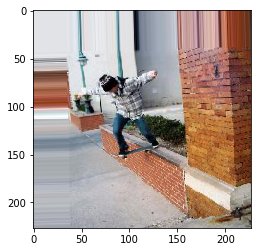

In [22]:
plt.imshow(X_train[1111])
print(y_train[1111])

In [26]:
# Train the CNN
model.fit(X_train,
          y_train,
          validation_data = (X_test, y_test),
          batch_size = 32,
          epochs = 5)

Train on 7929 samples, validate on 2643 samples
Epoch 1/5
7929/7929 [==============================] - 1615s 204ms/step - loss: 0.8582 - acc: 0.8571 - val_loss: 0.8557 - val_acc: 0.8571
Epoch 2/5
7929/7929 [==============================] - 1610s 203ms/step - loss: 0.8546 - acc: 0.8571 - val_loss: 0.8527 - val_acc: 0.8571
Epoch 3/5
7929/7929 [==============================] - 1540s 194ms/step - loss: 0.8519 - acc: 0.8571 - val_loss: 0.8502 - val_acc: 0.8571
Epoch 4/5
7929/7929 [==============================] - 1393s 176ms/step - loss: 0.8494 - acc: 0.8571 - val_loss: 0.8481 - val_acc: 0.8571
Epoch 5/5
7929/7929 [==============================] - 1547s 195ms/step - loss: 0.8475 - acc: 0.8571 - val_loss: 0.8462 - val_acc: 0.8571
